<a href="https://colab.research.google.com/github/alxogm/tutorials/blob/lyaforest/Lya_CF_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Correlation Function of the Lyman-$\alpha$ forest in  EDR

October 2023

Alma González (U. of Guanajuato)

This notebook has been tested in Colaboratory in October 2023.

### Table of Contents
* [Overview](#overview)
* [Installs, Imports and Downloads](#imports)
* [Accessing the Data](#data)
* [Auto-correlation](#autocorrelation)

<a class="anchor" id="overview"></a>
## Overview

This notebook demonstrates how to use the delta (flux fluctuations) files provided as Lyman-$\alpha$ catalog value added catalog, as part of the DESI Early Data Release. We will compute the auto-correlation function of the Lyman-$\alpha$ forest and its and cross-correlation function with quasars. Finally we will compare our results with those reported by the DESI collaboration in Gordon et.al. 2023 (arXiv:2308.10950)

<a class="anchor" id="imports"></a>
## Installs, Imports and Downloads

In [1]:
!pip install picca

In [13]:
from   google.colab import drive
import os
import sys
import subprocess
import bs4
import requests
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
import picca
from picca.wedgize import wedge
import fitsio
from astropy.table import Table

In [3]:
#Mount the Drive and define some useful paths
drivepath='/content/drive/'
drive.mount(drivepath, force_remount=True)
desiedr_path = drivepath + '/MyDrive/Bucaramanga/desi_edr/'
desicode_path = desiedr_path+'/desicode'
specprod = 'fuji'    # Internal name for the EDR
specprod_dir = desiedr_path+specprod
lya_dir = specprod_dir+'/lya'

Mounted at /content/drive/


In [4]:
#Create some necesary directories
if not os.path.exists(lya_dir):
  os.makedirs(lya_dir)

if not os.path.exists(lya_dir+'/Delta'):
  os.makedirs(lya_dir+'/Delta')

if not os.path.exists(lya_dir+'/Log'):
  os.makedirs(lya_dir+'/Log')

if not os.path.exists(lya_dir+'/Correlations'):
  os.makedirs(lya_dir+'/Correlations')

<a class="anchor" id="data"></a>
## Accessing the data
In this case the data is the Lyman-$\alpha$ catalog, or what we usually refers to as the "Deltas". These are a value added catalog of the DESI EDR, and all documentation can be found [here](https://data.desi.lbl.gov/doc/releases/edr/vac/lymanalpha/), and the relevant reference is [Cesar Ramirez-Perez et. al. 2023](https://arxiv.org/abs/2306.06312) ... For a very basic, but practical, introduction of how these deltas are computed see this [desihigh notebook](https://github.com/michaelJwilson/desihigh/blob/main/Lymanalphaforest_explorers.ipynb)

In [64]:
#Download the Delta Files
#you only need to do this the first time, so you can comment the following lines later if you prefer

url = "https://data.desi.lbl.gov/public/edr/vac/edr/lya/fuji/v0.3/Delta/"
r = requests.get(url)
data = bs4.BeautifulSoup(r.text, "html.parser")
for l in data.find_all("a")[1:]:
    r = requests.get(url + l["href"])
    local_delta=lya_dir+'/Delta/'+l["href"]
    if not os.path.exists(local_delta):
      tmp = urllib.request.urlretrieve(url + l["href"],local_delta)
      print ("Downloaded file "+local_delta)
    else: continue
print("All Delta files are on disk")

Exception ignored in: <function NpzFile.__del__ at 0x7ddd15d96320>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/numpy/lib/npyio.py", line 223, in __del__
  File "/usr/local/lib/python3.10/dist-packages/numpy/lib/npyio.py", line 218, in close
OSError: [Errno 107] Transport endpoint is not connected


All Delta files are on disk


Lest explore the content of one of the delta files and the attributes file.

In [9]:
delta_1=fitsio.FITS("/content/drive/MyDrive/Bucaramanga/desi_edr/fuji/lya/Delta/delta-1.fits.gz")
print(delta_1)


  file: /content/drive/MyDrive/Bucaramanga/desi_edr/fuji/lya/Delta/delta-1.fits.gz
  mode: READONLY
  extnum hdutype         hduname[v]
  0      IMAGE_HDU       
  1      IMAGE_HDU       LAMBDA
  2      BINARY_TBL      METADATA
  3      IMAGE_HDU       DELTA
  4      IMAGE_HDU       WEIGHT
  5      IMAGE_HDU       CONT


In [16]:
metadata=Table(delta_1["METADATA"][:])
metadata

LOS_ID,RA,DEC,Z,MEANSNR,TARGETID,NIGHT,PETAL,TILE
int64,float64,float64,float64,float64,int64,str12,str12,str12
39633561992563839,2.1517863661422707,1.4400019090819998,2.5575869269428586,3.4581153647923077,39633561992563839,,,
39633561996755338,2.1626690767626835,1.439794393601638,2.621267787265076,0.2572065576109337,39633561996755338,,,
39633561996756385,2.170680138994296,1.4382580544240757,2.353962325943498,1.2608535856650733,39633561996756385,,,
39633561174674576,2.18020469422799,1.4373293114993015,4.273964388519796,0.3417252018612574,39633561174674576,,,
39633565725493056,2.180832310664095,1.4630555938497154,2.1324286732719098,9.53773664217025,39633565725493056,,,
39633565725493798,2.1893241623811734,1.4624456084137094,2.276110332334394,1.968784252838793,39633565725493798,,,
39633565725493810,2.189464845107341,1.46373869453896,2.64127544882189,31.445668594220887,39633565725493810,,,
39633565725494060,2.192072349927443,1.460917742794321,2.5000555324498084,0.14854309594276485,39633565725494060,,,
39633560331617316,2.193450638104558,1.4312632501069884,2.7129910469341207,3.3384312877513427,39633560331617316,,,


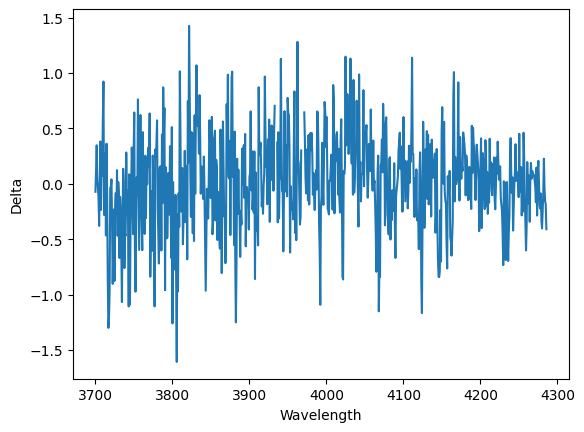

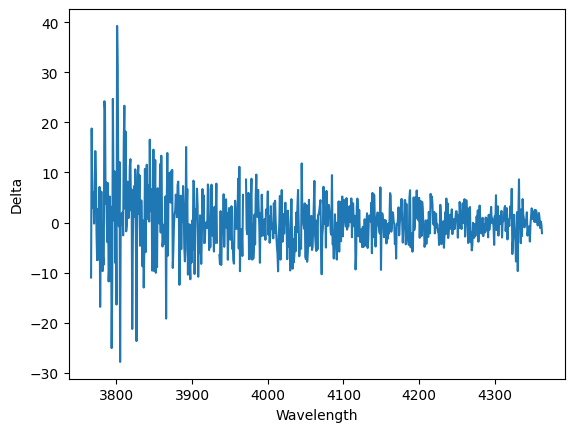

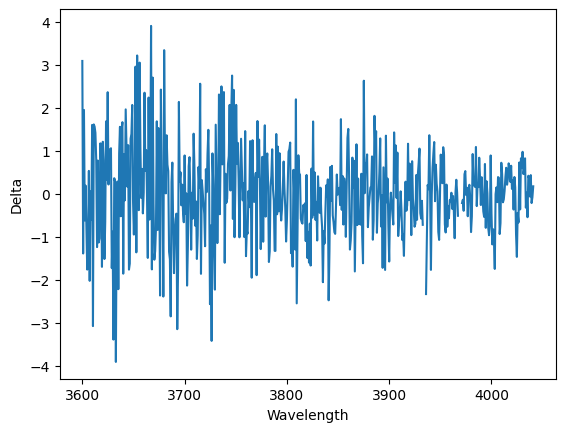

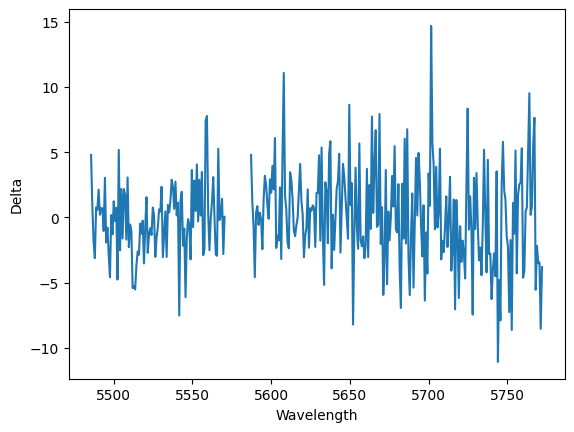

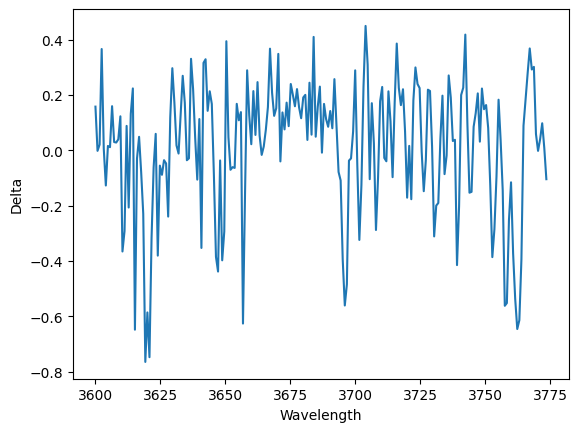

In [34]:
wavelenght=delta_1["LAMBDA"][:]

deltas=delta_1["DELTA"][:,:]

for i in range(5):
  plt.plot(wavelenght,deltas[i])
  plt.xlabel("Wavelength")
  plt.ylabel("Delta")
  #plt.xlim(3600,5772.)
  plt.show()

In [ ]:
#Exercise: Make plots of the continuum and the weights.

<a class="anchor" id="autocorrelation"></a>
## Computing the auto-correlation function.

We will use the [picca](https://github.com/igmhub/picca/tree/master) code. The  main reference for what is this code doing is (Gordon et.al 2023)[https://arxiv.org/abs/2308.10950]

In [46]:
os.chdir(lya_dir+'/Correlations')
!pwd

/content/drive/MyDrive/Bucaramanga/desi_edr/fuji/lya/Correlations


In [47]:
#With this instruction we can compute the Lya auto correlation. We limited it to use only 1000 spectra, for speedness, but for using all the deltas available you can remove the --nspec 1000 flag
!picca_cf.py --out cf_lya_lya.fits.gz --in-dir /content/drive/MyDrive/Bucaramanga/desi_edr/fuji/lya/Delta/ --nspec 1000

ATTENTION: Analysis is not blinded!
Om=0.315, Or=0.0, wl=-1.0
z_min_sources 0.0



done, npix = 18
picca_cf.py - Time reading data: 0.214 minutes
computing xi: 0.0%

Process ForkPoolWorker-2:
^C


In [22]:
#To compute the complete distortion Matrix but still do it in a reasonable time change the --nspec 1000 flag to --rej 0.99
!picca_dmat.py --out dmat.fits.gz --in-dir /content/drive/MyDrive/Bucaramanga/desi_edr/fuji/lya/Delta/ --nspec 1000

nproc 1
ATTENTION: Analysis is not blinded!
Om=0.315, Or=0.0, wl=-1.0



done, npix = 18
picca_dmat.py - Time reading data: 0.210 minutes
picca_dmat.py - Time computing distortion matrix: 0.000 minutes
computing xi: 0.0%
/usr/local/bin/picca_dmat.py:467: DeprecationWarning: The keyword arguments '{'comment': ['Sum of weight', 'Distortion matrix']}' are being ignored! This warning will be an error in a future version of `fitsio`!
  results.write([weights_dmat, dmat],
/usr/local/bin/picca_dmat.py:473: DeprecationWarning: The keyword arguments '{'comment': ['R-parallel', 'R-transverse', 'Redshift']}' are being ignored! This warning will be an error in a future version of `fitsio`!
  results.write([r_par, r_trans, z],
picca_dmat.py - Time total : 0.225 minutes


In [24]:
!picca_export.py --data cf_lya_lya.fits.gz --dmat dmat.fits.gz --out cf_lya_lya-exp.fits.gz

INFO: The covariance will be smoothed
Computing cov...
smoothing 2499

/usr/local/bin/picca_export.py:329: DeprecationWarning: The keyword arguments '{'comment': ['R-parallel', 'R-transverse', 'Redshift', 'Correlation', 'Covariance matrix', 'Distortion matrix', 'Number of pairs']}' are being ignored! This warning will be an error in a future version of `fitsio`!
  results.write([xi, r_par, r_trans, z, covariance, dmat, num_pairs],
/usr/local/bin/picca_export.py:335: DeprecationWarning: The keyword arguments '{'comment': ['R-parallel model', 'R-transverse model', 'Redshift model']}' are being ignored! This warning will be an error in a future version of `fitsio`!
  results.write([r_par_dmat, r_trans_dmat, z_dmat],


In [48]:
#Lets check that all the produced files are in place
!ls

cf_lya_lya-exp.fits.gz	     cf_lya_lya.fits.gz  Fig4_auto_corr_wedge.npz  wedges.py
cf_lya_lya-exp-full.fits.gz  dmat.fits.gz	 __pycache__


In [49]:
if not os.path.exists("Fig4_auto_corr_wedge.npz"):
  !wget https://zenodo.org/records/8244702/files/Fig4_auto_corr_wedge.npz?download=1
  !wget https://zenodo.org/records/8244702/files/wedges.py?download=1
  !mv Fig4_auto_corr_wedge.npz?download=1 Fig4_auto_corr_wedge.npz
  !mv wedges.py?download=1 wedges.py
  print("Downloaded Fig4_auto_corr_wedge.npz")
  print("Downloaded wedges.py")
else:
  print("EDR CF files from Gordon 2023 are already on disk")

#Read the file with the EDR+M2 correlation function
Gordon2023=np.load("Fig4_auto_corr_wedge.npz")
from wedges import Wedge

EDR CF files from Gordon 2023 are already on disk


In [50]:
#Lets create a function that plot the results, and compares with eBOSS DR16 results.
def plot_cf(file_xis,xi_edr,rps=(-300,300,150), power=2,
                 mus=[1., 0.95, 0.8, 0.5, 0], figsize=(6, 7),
                 absMus=True, label=None,labels=None,colors=None):

    f, (axs) = plt.subplots(nrows=2, ncols=2, figsize=(12,8))

    for k,file_xi in enumerate(file_xis):
        #- Read correlation function and covariance matrix
        h = fitsio.FITS(file_xi)
        try:
            da = h[1]['DA_BLIND'][:]
        except:
            da = h[1]['DA'][:]
        co = h[1]['CO'][:]
        hh = h[1].read_header()
        rpmin = hh['RPMIN']
        rpmax = hh['RPMAX']
        rtmin = 0
        rtmax = hh['RTMAX']
        nrp = hh['NP']
        nrt = hh['NT']
        h.close()

        j=0

        for i, (mumax,mumin) in enumerate(zip(mus[:-1],mus[1:])):
            b = picca.wedgize.wedge(mumin=mumin, mumax=mumax,
                                rpmin=rpmin, rpmax=rpmax,
                                rtmin=rtmin, rtmax=rtmax,
                                nrt=nrt, nrp=nrp, absoluteMu=absMus,
                                rmin=0., rmax=min(rpmax, rtmax),
                                nr=min(nrt, nrp))
            r,d,c = b.wedge(da,co)

            nrows = 2

                        #-- Wedges and best model
            y = d*r**power
            dy = np.sqrt(c.diagonal())*r**power



            ###
            b2 = Wedge(mu=(mumin,mumax),
              rp=rps,
              rt=(0,200,50),
              r=(0., 200., 50))

            xi=xi_edr['fugu_xi']
            cov=xi_edr['fugu_cov']

            r2,d2,c2=b2.__call__(xi,cov)
            c2 = np.sqrt(np.diagonal(c2))
            y2 = d2*r2**power
            dy2 =c2*r**power
            ####
            if absMus:
                if j==0:
                    axs[j//2][j%2].errorbar(
                    r, y, dy, fmt=".",label=labels[k],color=colors[k],alpha=0.7)
                    axs[j//2][j%2].errorbar(
                    r2, y2, dy2, fmt=".",label='Gordon et. al 2023',color='b',alpha=0.7)
                    axs[j//2][j%2].axvline(100)

                else:
                    axs[j//2][j%2].errorbar(
                        r, y, dy, fmt=".",color=colors[k],alpha=0.7)
                    axs[j//2][j%2].errorbar(
                        r2, y2, dy2, fmt=".",color='b',alpha=0.7)
                    axs[j//2][j%2].axvline(100)
            else:
                axs[j//2][j%2].errorbar(
                    r, y, dy, fmt="o")
                axs[j//2][j%2].errorbar(
                    r2, y2, dy2, fmt="o")

            axs[j//2][j%2].set_ylabel(r"$r^{power}\xi(r)$".format(power=power))
            if j//2==1:
                axs[j//2][j%2].set_xlabel(r"$r \, [h^{-1}\, \mathrm{Mpc}]$")
            axs[j//2][j%2].legend(loc="best", fontsize=12)
            #axs[j//2][j%2].grid(True)
            j+=1
        axs[0][0].set_title(r"${}<\mu<{}$".format(0.95,1))
        axs[0][1].set_title(r"${}<\mu<{}$".format(0.8,0.95))
        axs[1][0].set_title(r"${}<\mu<{}$".format(0.5,8))
        axs[1][1].set_title(r"${}<\mu<{}$".format(0,0.5))

        plt.tight_layout()

    plt.show()

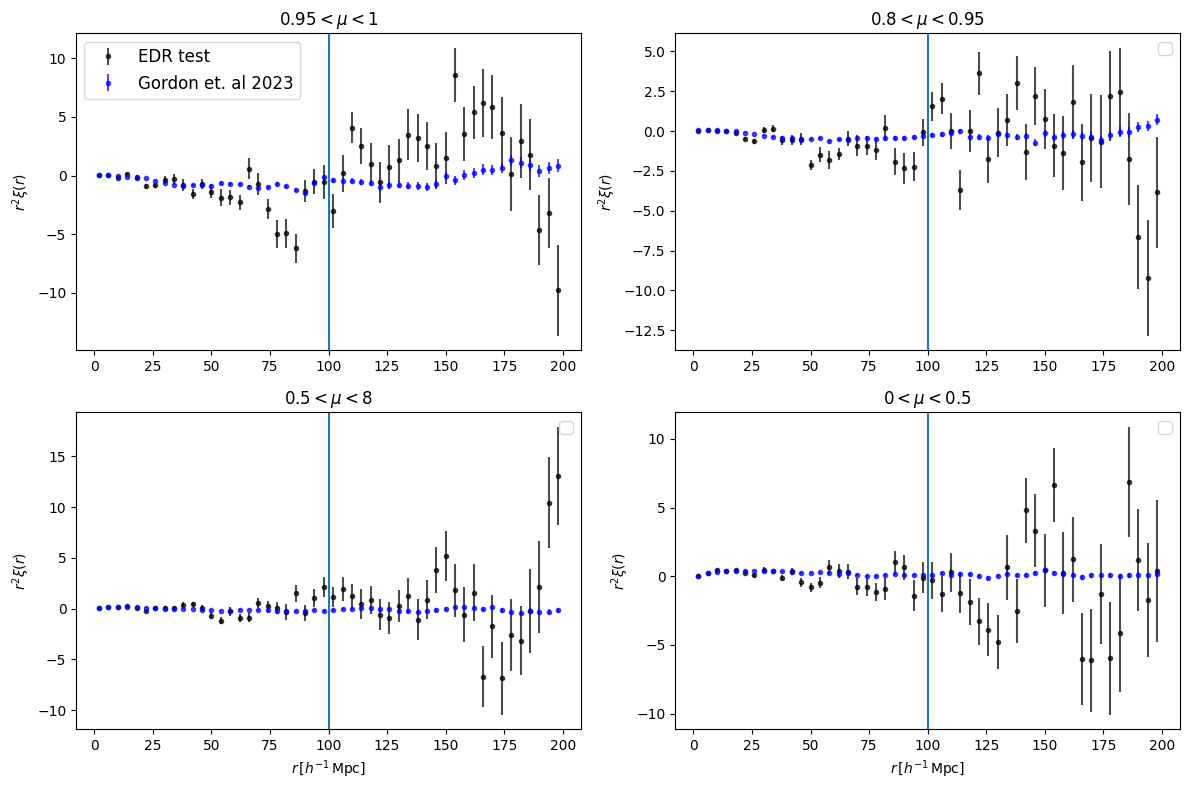

In [54]:
cf="cf_lya_lya-exp.fits.gz"
plot_cf([cf],Gordon2023,rps=(0,300,75), labels=["EDR test"],colors=['k'])

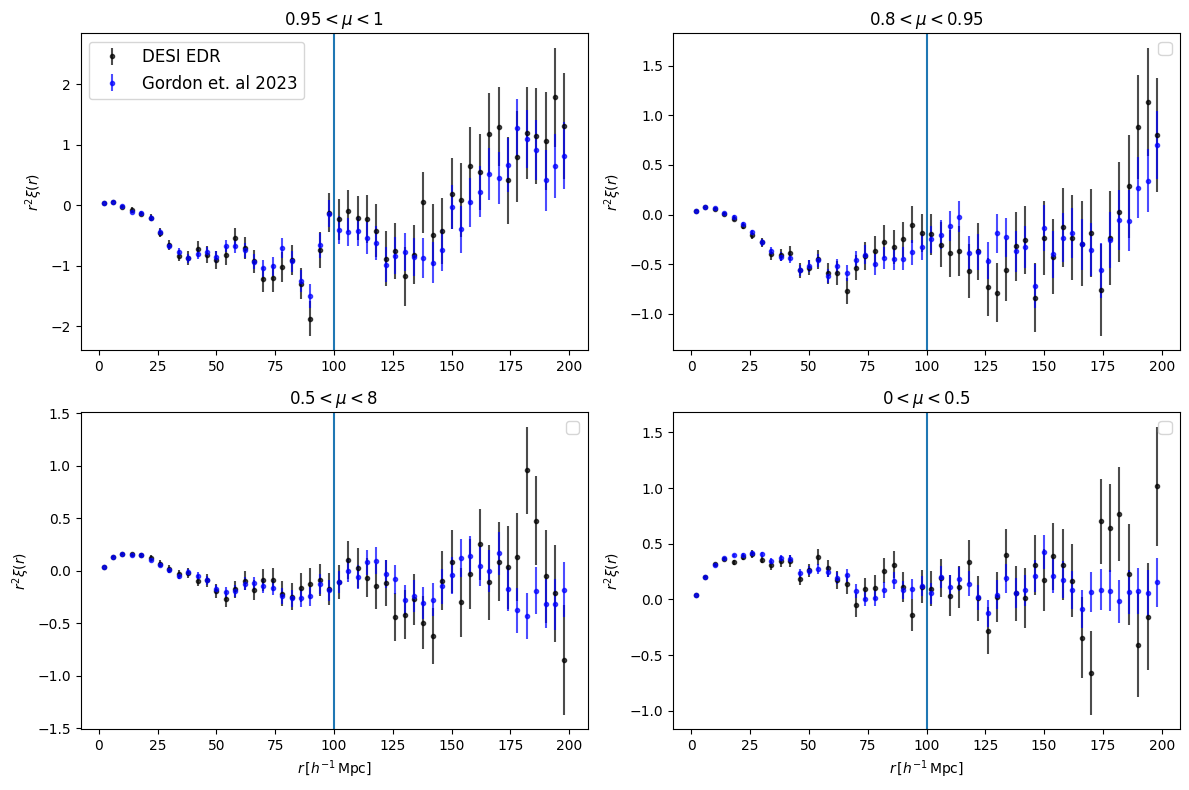

In [53]:
cf_full="cf_lya_lya-exp-full.fits.gz"
plot_cf([cf_full],Gordon2023,rps=(0,300,75), labels=["DESI EDR"],colors=['k'])